In [7]:
import warnings
warnings.filterwarnings('ignore')


import pandas as pd

# Leer el archivo que bajamos
df = pd.read_csv('Churn_Modelling.csv')

# Ver las primeras 5 filas
print(df.head())

   RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  
4         790

In [2]:
# Borramos columnas que no aportan valor estratégico
df_limpio = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

# Ver cómo quedó
print(df_limpio.head())

   CreditScore Geography  Gender  Age  Tenure    Balance  NumOfProducts  \
0          619    France  Female   42       2       0.00              1   
1          608     Spain  Female   41       1   83807.86              1   
2          502    France  Female   42       8  159660.80              3   
3          699    France  Female   39       1       0.00              2   
4          850     Spain  Female   43       2  125510.82              1   

   HasCrCard  IsActiveMember  EstimatedSalary  Exited  
0          1               1        101348.88       1  
1          0               1        112542.58       0  
2          1               0        113931.57       1  
3          0               0         93826.63       0  
4          1               1         79084.10       0  


In [3]:
# 1. Traducir los nombres de las columnas
df_limpio.columns = [
    'Puntaje_Credito', 'Pais', 'Genero', 'Edad', 'Tenencia', 
    'Saldo', 'Num_Productos', 'Tiene_Tarjeta', 'Es_Miembro_Activo', 
    'Salario_Estimado', 'Se_Fue'
]

# 2. Crear una categoría nueva (Ingeniería de datos básica)
# Vamos a etiquetar a los clientes según su nivel de saldo
def categorizar_saldo(saldo):
    if saldo == 0:
        return 'Sin Saldo'
    elif saldo < 50000:
        return 'Saldo Bajo'
    elif saldo < 150000:
        return 'Saldo Medio'
    else:
        return 'Saldo Alto'

df_limpio['Nivel_Saldo'] = df_limpio['Saldo'].apply(categorizar_saldo)

# Ver cómo quedó nuestra nueva columna
print(df_limpio[['Saldo', 'Nivel_Saldo']].head())

       Saldo  Nivel_Saldo
0       0.00    Sin Saldo
1   83807.86  Saldo Medio
2  159660.80   Saldo Alto
3       0.00    Sin Saldo
4  125510.82  Saldo Medio


In [4]:
# Guardar el trabajo final de la semana 1
df_limpio.to_parquet('datos_banco_silver.parquet')
print("¡Archivo 'datos_banco_silver.parquet' guardado con éxito!")

¡Archivo 'datos_banco_silver.parquet' guardado con éxito!


In [5]:
# ¿Se van más los hombres o las mujeres?
print(df_limpio.groupby('Genero')['Se_Fue'].mean())

Genero
Female    0.250715
Male      0.164559
Name: Se_Fue, dtype: float64


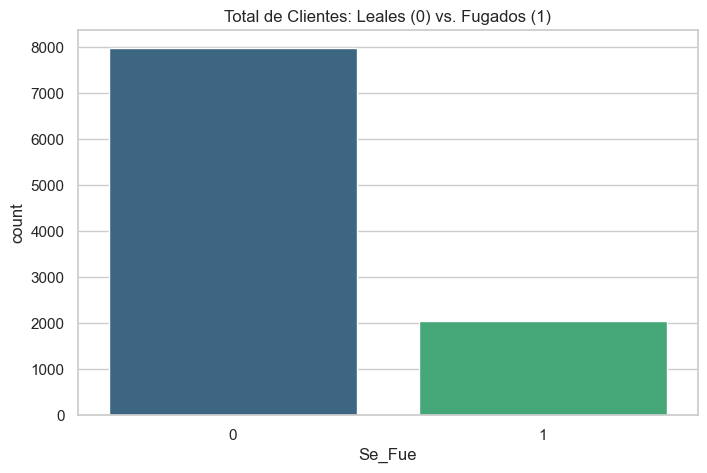

In [8]:
import warnings
warnings.filterwarnings('ignore')


import seaborn as sns
import matplotlib.pyplot as plt

# Configuramos el estilo de los gráficos
sns.set_theme(style="whitegrid")

# Gráfico 1: ¿Cuánta gente se ha ido realmente?
plt.figure(figsize=(8, 5))
sns.countplot(x='Se_Fue', data=df_limpio, palette='viridis')
plt.title('Total de Clientes: Leales (0) vs. Fugados (1)')
plt.show()

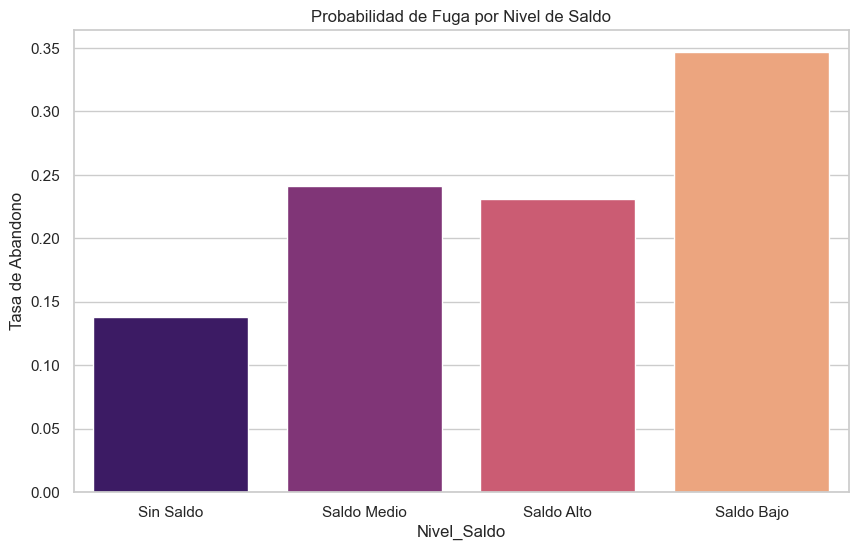

In [9]:
plt.figure(figsize=(10, 6))
# Usamos la columna que creaste en la Semana 1
sns.barplot(x='Nivel_Saldo', y='Se_Fue', data=df_limpio, palette='magma', ci=None)
plt.title('Probabilidad de Fuga por Nivel de Saldo')
plt.ylabel('Tasa de Abandono')
plt.show()


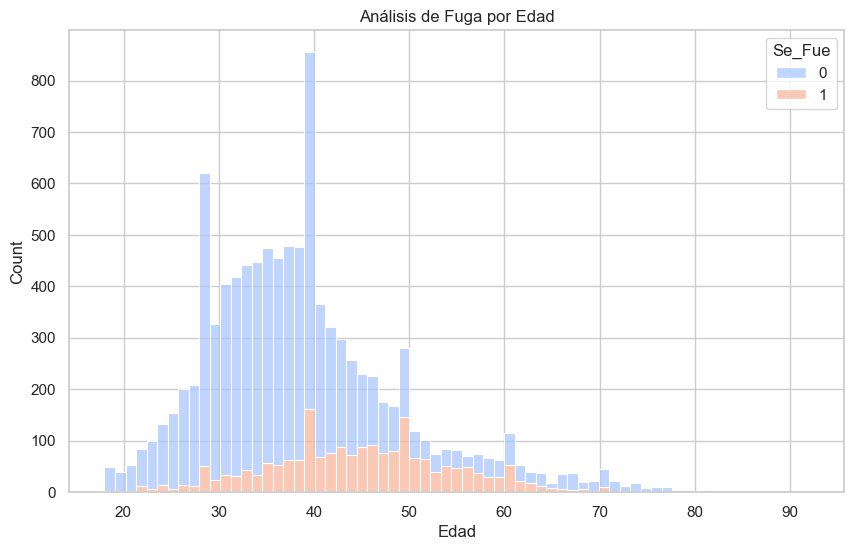

In [10]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df_limpio, x='Edad', hue='Se_Fue', multiple="stack", palette='coolwarm')
plt.title('Análisis de Fuga por Edad')
plt.show()